# Automated CapsnetsS2I train + test

First, import stuff

In [1]:
import model_s2i
import data_loader
import tensorflow as tf

W0421 19:06:24.427685 4473683392 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

## Load word vectors and data

In [7]:
WORD_VEC_SCENARIO = "FastText-300-verbsDatasets-synAntVSP-dia"

word2vec_path = '../rad-antonyms/counterfitting-results/FastText-300-verbsDatasets-synAntVSP-dia.vec'

# No diacritics data
training_data_paths = [
#         '../data-capsnets/scenario0/train.txt',
#         '../data-capsnets/scenario1/train.txt',
#         '../data-capsnets/scenario2/train.txt',
#         '../data-capsnets/scenario3.1/train.txt',
#         '../data-capsnets/scenario3.2/train.txt',
#         '../data-capsnets/scenario3.3/train.txt',
        '../data-capsnets/diacritics/scenario0/train.txt',
        '../data-capsnets/diacritics/scenario1/train.txt',
        '../data-capsnets/diacritics/scenario2/train.txt',
        '../data-capsnets/diacritics/scenario31/train.txt',
        '../data-capsnets/diacritics/scenario32/train.txt',
        '../data-capsnets/diacritics/scenario33/train.txt',
        
    ]
test_data_paths = [
#     '../data-capsnets/scenario0/test.txt',
#     '../data-capsnets/scenario1/test.txt',
#     '../data-capsnets/scenario2/test.txt',
#     '../data-capsnets/scenario3.1/test.txt',
#     '../data-capsnets/scenario3.2/test.txt',
#     '../data-capsnets/scenario3.3/test.txt',
    '../data-capsnets/diacritics/scenario0/test.txt',
    '../data-capsnets/diacritics/scenario1/test.txt',
    '../data-capsnets/diacritics/scenario2/test.txt',
    '../data-capsnets/diacritics/scenario31/test.txt',
    '../data-capsnets/diacritics/scenario32/test.txt',
    '../data-capsnets/diacritics/scenario33/test.txt',
]

scenario_nums = [
#     '0_' + WORD_VEC_SCENARIO,
#     '1_' + WORD_VEC_SCENARIO,
#     '2_' + WORD_VEC_SCENARIO,
#     '31_' + WORD_VEC_SCENARIO,
#     '32_' + WORD_VEC_SCENARIO,
#     '33_' + WORD_VEC_SCENARIO,
    '0_dia_' + WORD_VEC_SCENARIO,
    '1_dia_' + WORD_VEC_SCENARIO,
    '2_dia_' + WORD_VEC_SCENARIO,
    '31_dia_' + WORD_VEC_SCENARIO,
    '32_dia_' + WORD_VEC_SCENARIO,
    '33_dia_' + WORD_VEC_SCENARIO,
]

In [4]:
print('------------------load word2vec begin-------------------')
w2v = data_loader.load_w2v(word2vec_path)
print('------------------load word2vec end---------------------')

------------------load word2vec begin-------------------
loading time took -00.06
------------------load word2vec end---------------------


# Flag setting functions + utils

In [5]:
import csv

def set_flags(data, scenario):
    FLAGS = tf.app.flags.FLAGS

    tf.app.flags.DEFINE_boolean('save_model', False, 'save model to disk')
    tf.app.flags.DEFINE_string('summaries_dir', './logs', 'tensorboard summaries')
    tf.app.flags.DEFINE_string('ckpt_dir', './saved_models/', 'check point dir')
    tf.app.flags.DEFINE_string('scenario_num', scenario, 'Scenario number')
    tf.app.flags.DEFINE_string('errors_dir', './errors/', 'Errors dir')
    
    vocab_size, word_emb_size = data['embedding'].shape
    _, max_sentence_length = data['x_tr'].shape
    intents_number = len(data['intents_dict'])
    slots_number = len(data['slots_dict'])
    hidden_size = 64

    tf.app.flags.DEFINE_float('keep_prob', 1, 'embedding dropout keep rate for training')
    tf.app.flags.DEFINE_integer('hidden_size', hidden_size, 'embedding vector size')
    tf.app.flags.DEFINE_integer('batch_size', 32, 'batch size')
    tf.app.flags.DEFINE_integer('num_epochs', 20, 'num of epochs')
    tf.app.flags.DEFINE_integer('vocab_size', vocab_size, 'vocab size of word vectors')
    tf.app.flags.DEFINE_integer('max_sentence_length', max_sentence_length, 'max number of words in one sentence')
    tf.app.flags.DEFINE_integer('intents_nr', intents_number, 'intents_number')  #
    tf.app.flags.DEFINE_integer('slots_nr', slots_number, 'slots_number')  #
    tf.app.flags.DEFINE_integer('word_emb_size', word_emb_size, 'embedding size of word vectors')
    tf.app.flags.DEFINE_boolean('use_embedding', True, 'whether to use embedding or not.')
    tf.app.flags.DEFINE_float('learning_rate', 0.01, 'learning rate')
    tf.app.flags.DEFINE_integer('slot_routing_num', 2, 'slot routing num')
    tf.app.flags.DEFINE_integer('intent_routing_num', 3, 'intent routing num')
    tf.app.flags.DEFINE_integer('intent_output_dim', 16, 'intent output dimension')
    tf.app.flags.DEFINE_integer('slot_output_dim', 2 * hidden_size, 'slot output dimension')
    tf.app.flags.DEFINE_integer('d_a', 20, 'self attention weight hidden units number')
    tf.app.flags.DEFINE_integer('r', 5, 'number of self attention heads')
    tf.app.flags.DEFINE_float('alpha', 0.0001, 'coefficient for self attention loss')
    tf.app.flags.DEFINE_integer('n_splits', 3, 'Number of cross-validation splits')
    
    tf.app.flags.DEFINE_string('f', '', 'kernel') # Without this there's an error: unknown command line flag 'f'
    
    return FLAGS

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)
        
def write_csv(run_results):
    with open('results/results_{}.csv'.format(WORD_VEC_SCENARIO), 'w') as f:
        header_line = ['Scenario', 'Intent F1', 'Slot F1']
        writer = csv.writer(f)
        writer.writerow(header_line)
        for k, v in run_results.items():
            scenario_num = [k]
            intent_score = [v['intent_f1']]
            slot_score = [v['slot_f1']]
            l = scenario_num + intent_score + slot_score
            writer.writerow(l)

In [9]:
# In case it's needed
del_all_flags(FLAGS)

------------------read datasets begin-------------------
------------------read datasets end---------------------
TRAINING 0_dia_FastText-300-verbsDatasets-synAntVSP-dia
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.076923
F score 0.076923
Slot filling
F1 score: 0.025240
Accuracy: 0.026496
------------------epoch :  0  Loss:  20.96761 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.412821
F score 0.412821
Slot filling
F1 score: 0.265600
Accuracy: 0.918803
Current F score mean 0.33921025641025637
Best F score mean 0.33921025641025637
------------------epoch :  1  Loss:  9.724541 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.769231
F score 0.769231
Slot filling
F1 scor

------------------epoch :  5  Loss:  0.2588796 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.992308
F score 0.992308
Slot filling
F1 score: 0.968109
Accuracy: 0.995897
Current F score mean 0.9802085158577186
Best F score mean 0.9852672750977836
------------------epoch :  6  Loss:  0.21667534 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.994872
F score 0.994872
Slot filling
F1 score: 0.972665
Accuracy: 0.996581
Current F score mean 0.9837684714677881
Best F score mean 0.9852672750977836
------------------epoch :  7  Loss:  0.1708627 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.992308
F score 0.992308
Slot filling
F1 score: 0.968182
Accuracy: 0.996410
Current F score mean 0.9802447552447552
Best F score mean 0.9852672750977836
------------------epoch :  8  Loss:  0.14895006 ----------------------
           VALIDATI

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.994872
F score 0.994872
Slot filling
F1 score: 0.977273
Accuracy: 0.997778
Current F score mean 0.9860722610722611
Best F score mean 0.9860722610722611
------------------epoch :  12  Loss:  0.06847523 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.994872
F score 0.994872
Slot filling
F1 score: 0.977273
Accuracy: 0.997778
Current F score mean 0.9860722610722611
Best F score mean 0.9860722610722611
------------------epoch :  13  Loss:  0.06302723 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.994872
F score 0.994872
Slot filling
F1 score: 0.977273
Accuracy: 0.997778
Current F score mean 0.9860722610722611
Best F score mean 0.9860722610722611
------------------epoch :  14  Loss:  0.05846337 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.9948

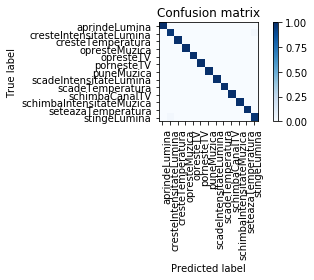

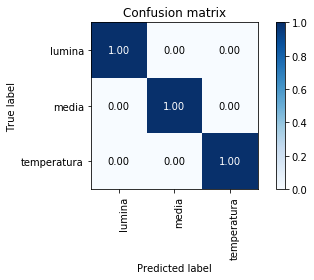

Intent F1: 0.996154
Slot F1: 0.982338
------------------read datasets begin-------------------
------------------read datasets end---------------------
TRAINING 1_dia_FastText-300-verbsDatasets-synAntVSP-dia
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.088235
F score 0.088235
Slot filling
F1 score: 0.038368
Accuracy: 0.319683
------------------epoch :  0  Loss:  16.41683 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.600000
F score 0.600000
Slot filling
F1 score: 0.337349
Accuracy: 0.905430
Current F score mean 0.46867469879518076
Best F score mean 0.46867469879518076
------------------epoch :  1  Loss:  2.9034767 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.92941

------------------epoch :  5  Loss:  0.3368144 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997059
F score 0.997059
Slot filling
F1 score: 0.985075
Accuracy: 0.998869
Current F score mean 0.9910667251975417
Best F score mean 0.9982698961937716
------------------epoch :  6  Loss:  0.28873774 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997059
F score 0.997059
Slot filling
F1 score: 0.985075
Accuracy: 0.998869
Current F score mean 0.9910667251975417
Best F score mean 0.9982698961937716
------------------epoch :  7  Loss:  0.25290805 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.985075
Accuracy: 0.998869
Current F score mean 0.9925373134328358
Best F score mean 0.9982698961937716
------------------epoch :  8  Loss:  0.22434384 ----------------------
           VALIDAT

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.990741
Accuracy: 0.999090
Current F score mean 0.9953703703703703
Best F score mean 0.9994232987312572
------------------epoch :  12  Loss:  0.074425526 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.990741
Accuracy: 0.999090
Current F score mean 0.9953703703703703
Best F score mean 0.9994232987312572
------------------epoch :  13  Loss:  0.06889145 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.990741
Accuracy: 0.999090
Current F score mean 0.9953703703703703
Best F score mean 0.9994232987312572
------------------epoch :  14  Loss:  0.064153895 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.00

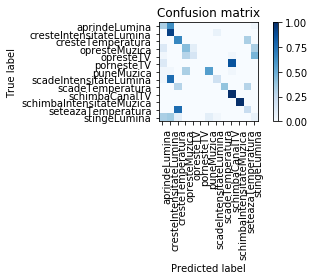

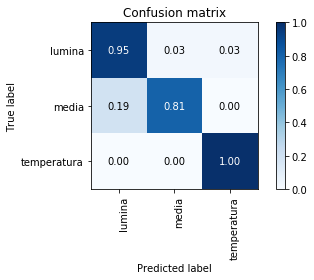

Intent F1: 0.461538
Slot F1: 0.816092
------------------read datasets begin-------------------
------------------read datasets end---------------------
TRAINING 2_dia_FastText-300-verbsDatasets-synAntVSP-dia
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.110701
F score 0.110701
Slot filling
F1 score: 0.030868
Accuracy: 0.035363
------------------epoch :  0  Loss:  19.15953 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.704797
F score 0.704797
Slot filling
F1 score: 0.411141
Accuracy: 0.893604
Current F score mean 0.5579688157624282
Best F score mean 0.5579688157624282
------------------epoch :  1  Loss:  5.670371 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.922509
F

------------------epoch :  6  Loss:  0.4269422 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.992665
Accuracy: 0.999385
Current F score mean 0.9963325183374083
Best F score mean 1.0
------------------epoch :  7  Loss:  0.23185761 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.992665
Accuracy: 0.999385
Current F score mean 0.9963325183374083
Best F score mean 1.0
------------------epoch :  8  Loss:  0.19353145 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.996328
Accuracy: 0.999692
Current F score mean 0.9981640146878825
Best F score mean 1.0
------------------epoch :  9  Loss:  0.16681473 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection


------------------epoch :  14  Loss:  0.12167676 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.989038
Accuracy: 0.999077
Current F score mean 0.9945188794153471
Best F score mean 1.0
------------------epoch :  15  Loss:  0.1133275 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.989038
Accuracy: 0.999077
Current F score mean 0.9945188794153471
Best F score mean 1.0
------------------epoch :  16  Loss:  0.10607956 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.989038
Accuracy: 0.999077
Current F score mean 0.9945188794153471
Best F score mean 1.0
------------------epoch :  17  Loss:  0.099725135 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detec

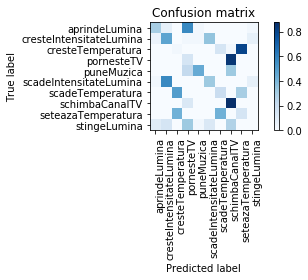

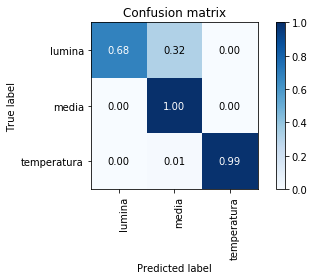

Intent F1: 0.295000
Slot F1: 0.397276
------------------read datasets begin-------------------
------------------read datasets end---------------------
TRAINING 31_dia_FastText-300-verbsDatasets-synAntVSP-dia
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.125523
F score 0.125523
Slot filling
F1 score: 0.012098
Accuracy: 0.020223
------------------epoch :  0  Loss:  19.400202 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.627615
F score 0.627615
Slot filling
F1 score: 0.290076
Accuracy: 0.906904
Current F score mean 0.45884569931968444
Best F score mean 0.45884569931968444
------------------epoch :  1  Loss:  5.70143 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.93305

------------------epoch :  5  Loss:  0.38196495 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.979079
F score 0.979079
Slot filling
F1 score: 0.960993
Accuracy: 0.995816
Current F score mean 0.9700362028546841
Best F score mean 0.9955908289241622
------------------epoch :  6  Loss:  0.33971074 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.987448
F score 0.987448
Slot filling
F1 score: 0.956217
Accuracy: 0.996513
Current F score mean 0.971832430808462
Best F score mean 0.9955908289241622
------------------epoch :  7  Loss:  0.31193748 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.991632
F score 0.991632
Slot filling
F1 score: 0.973545
Accuracy: 0.997211
Current F score mean 0.9825883863540767
Best F score mean 0.9955908289241622
------------------epoch :  8  Loss:  0.22710158 ----------------------
           VALIDAT

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.995781
F score 0.995781
Slot filling
F1 score: 0.994671
Accuracy: 0.999297
Current F score mean 0.9952259969572288
Best F score mean 0.9961172457132598
------------------epoch :  12  Loss:  0.11048145 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.995781
F score 0.995781
Slot filling
F1 score: 0.994671
Accuracy: 0.999297
Current F score mean 0.9952259969572288
Best F score mean 0.9961172457132598
------------------epoch :  13  Loss:  0.10198497 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.995781
F score 0.995781
Slot filling
F1 score: 0.994671
Accuracy: 0.999297
Current F score mean 0.9952259969572288
Best F score mean 0.9961172457132598
------------------epoch :  14  Loss:  0.094875775 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.995

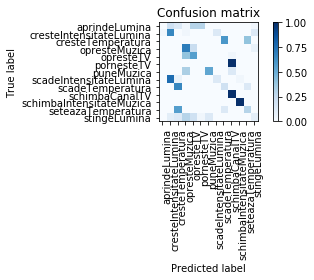

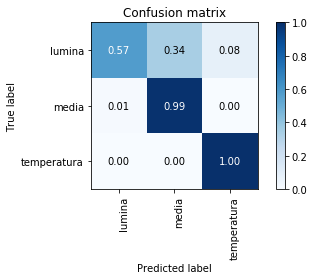

Intent F1: 0.400000
Slot F1: 0.334385
------------------read datasets begin-------------------
------------------read datasets end---------------------
TRAINING 32_dia_FastText-300-verbsDatasets-synAntVSP-dia
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.125000
F score 0.125000
Slot filling
F1 score: 0.006936
Accuracy: 0.067708
------------------epoch :  0  Loss:  19.613571 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.604167
F score 0.604167
Slot filling
F1 score: 0.315789
Accuracy: 0.925347
Current F score mean 0.45997807017543857
Best F score mean 0.45997807017543857
------------------epoch :  1  Loss:  6.7433147 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.841

------------------epoch :  5  Loss:  0.43020058 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.987500
F score 0.987500
Slot filling
F1 score: 0.961303
Accuracy: 0.996875
Current F score mean 0.9744017311608961
Best F score mean 0.9896857923497269
------------------epoch :  6  Loss:  0.5337254 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.991667
F score 0.991667
Slot filling
F1 score: 0.959184
Accuracy: 0.996181
Current F score mean 0.9754251700680272
Best F score mean 0.9896857923497269
------------------epoch :  7  Loss:  0.25050876 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.991667
F score 0.991667
Slot filling
F1 score: 0.967078
Accuracy: 0.996875
Current F score mean 0.9793724279835392
Best F score mean 0.9896857923497269
------------------epoch :  8  Loss:  0.21711342 ----------------------
           VALIDAT

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.973843
Accuracy: 0.996499
Current F score mean 0.9869215291750504
Best F score mean 0.9917695473251029
------------------epoch :  12  Loss:  0.18616761 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.973843
Accuracy: 0.996499
Current F score mean 0.9869215291750504
Best F score mean 0.9917695473251029
------------------epoch :  13  Loss:  0.169568 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.973843
Accuracy: 0.996499
Current F score mean 0.9869215291750504
Best F score mean 0.9917695473251029
------------------epoch :  14  Loss:  0.15632033 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000

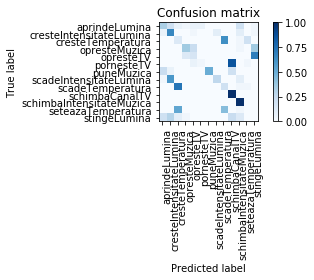

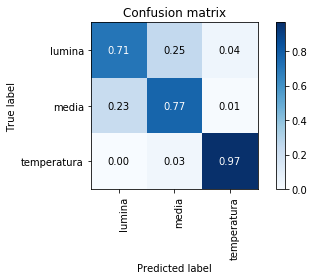

Intent F1: 0.358974
Slot F1: 0.317730
------------------read datasets begin-------------------
------------------read datasets end---------------------
TRAINING 33_dia_FastText-300-verbsDatasets-synAntVSP-dia
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.153846
F score 0.153846
Slot filling
F1 score: 0.048212
Accuracy: 0.048291
------------------epoch :  0  Loss:  29.966587 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.353846
F score 0.353846
Slot filling
F1 score: 0.281996
Accuracy: 0.844444
Current F score mean 0.31792090772567994
Best F score mean 0.31792090772567994
------------------epoch :  1  Loss:  7.3782945 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.841

------------------epoch :  5  Loss:  0.28215036 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.948718
F score 0.948718
Slot filling
F1 score: 0.972477
Accuracy: 0.995299
Current F score mean 0.9605975064690662
Best F score mean 0.9935235343686049
------------------epoch :  6  Loss:  0.1854768 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.974359
F score 0.974359
Slot filling
F1 score: 0.984802
Accuracy: 0.997009
Current F score mean 0.9795807029849584
Best F score mean 0.9935235343686049
------------------epoch :  7  Loss:  0.13633399 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.989744
F score 0.989744
Slot filling
F1 score: 0.981818
Accuracy: 0.997009
Current F score mean 0.9857808857808859
Best F score mean 0.9935235343686049
------------------epoch :  8  Loss:  0.10915325 ----------------------
           VALIDAT

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.989744
F score 0.989744
Slot filling
F1 score: 0.992343
Accuracy: 0.998291
Current F score mean 0.9910433109514274
Best F score mean 0.9946564885496183
------------------epoch :  12  Loss:  0.14592102 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.989744
F score 0.989744
Slot filling
F1 score: 0.995406
Accuracy: 0.998718
Current F score mean 0.9925747045195744
Best F score mean 0.9946564885496183
------------------epoch :  13  Loss:  0.13346651 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.989744
F score 0.989744
Slot filling
F1 score: 0.995406
Accuracy: 0.998718
Current F score mean 0.9925747045195744
Best F score mean 0.9946564885496183
------------------epoch :  14  Loss:  0.12272804 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.9897

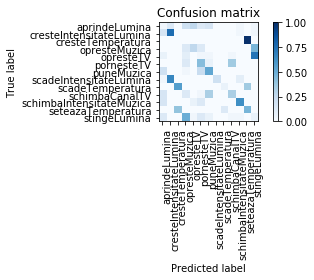

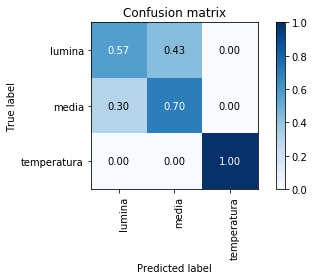

Intent F1: 0.282051
Slot F1: 0.434132


In [10]:
import train
import test

results = dict()
for i in range(len(training_data_paths)):
    
    # Load data
    data = data_loader.read_datasets(w2v, training_data_paths[i], test_data_paths[i], test=True)
    
    FLAGS = set_flags(data, scenario=scenario_nums[i])
    
    # Train model
    print('TRAINING ' + scenario_nums[i])
    train.train(model_s2i.CapsNetS2I, data, FLAGS, batches_rand=False)
    
    # Test model
    print('TESTING ' + scenario_nums[i])
    intent_f, slot_f = test.test(model_s2i.CapsNetS2I, data, FLAGS)
    results[scenario_nums[i]] = dict()
    results[scenario_nums[i]]['intent_f1'] = intent_f
    results[scenario_nums[i]]['slot_f1'] = slot_f
        
    # Reset flags
    del_all_flags(FLAGS)

write_csv(results)